# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Importing Libraries

In [123]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
% matplotlib inline

# reading the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploring Data

In [124]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [125]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [126]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [127]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [128]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [129]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# Data Cleaning Functions

In [130]:
def clean_portfolio():
    '''
    This function cleans Portfolio Dataframe
    
    INPUT:
    None
    
    OUTPUT:
    portfolio - Cleaned Portfolio Dataframe
    
    '''
    # changing the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # Isolating Channel Column Attributes
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # applying one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # dropping the channels and offer_type column
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    return cleaned_portfolio

In [131]:
def clean_profile():
    '''
    This function cleans Profile Dataframe
    
    INPUT:
    None
    
    OUTPUT:
    profile - The Cleaned Profile Dataframe
    
    '''
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    #Transforming became_member column to Proper Date Format
    profile['date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    profile['year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
    profile['month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
    profile['day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
    
    return profile

In [132]:
def clean_transcript():
    '''
    This Function cleans Transcript Dataframe
    
    INPUT:
    None
    
    OUTPUT:
    offer - Cleaned learned offer Dataframe
    
    '''
    # extract the rows that are related to offer received, offer viewed and offer completed
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extracting offer_id from value Column
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offer

## Cleaning all data

In [133]:
portfolio = clean_portfolio()
profile = clean_profile()
offers = clean_transcript()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### Exloring Cleaned Data

In [134]:
portfolio.head()

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [135]:
profile.head()

,age,became_member_on,gender,id,income,memberdays,date,year,month,day
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1020,2017-07-15,2017,7,15
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1087,2017-05-09,2017,5,9
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,735,2018-04-26,2018,4,26
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,811,2018-02-09,2018,2,9
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,901,2017-11-11,2017,11,11


# Transforming Data

In [136]:
#renaming 'id' column of Profile as 'Person'
profile_renamed = profile.rename(columns={'id':'person'})

#merging offers and profile_renamed as 'combined'
combined = pd.merge(offers, profile_renamed, on='person')

# Filterig 'Type' and 'Value' columns of 'combined' Dataframe
combined['type'] = combined['value'].apply(lambda x: list(x.keys())[0])
combined['value'] = combined['value'].apply(lambda x: list(x.values())[0])

#renaming 'id' column of portfolio as 'offer_id'
portfolio_renamed = portfolio.rename(columns={'id':'offer_id'})

# combining all three .json files
all_data = pd.merge(combined, portfolio_renamed, on='offer_id')
#all_data.head()

# Vizualizing Data

Text(0.5,0,'Income')

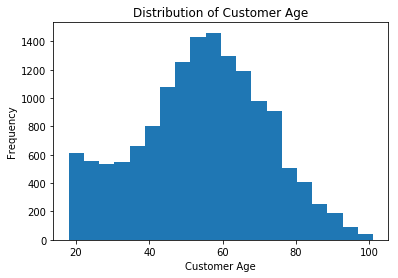

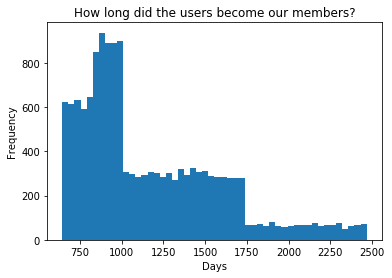

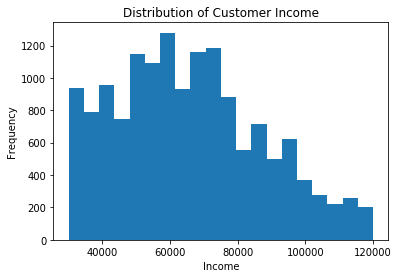

In [137]:
user_age = profile['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age')
user_age.set_xlabel("Customer Age")

plt.figure()
memberdays = profile['memberdays'].plot(kind='hist', bins=50, title='How long did the users become our members?')
memberdays.set_xlabel("Days")

plt.figure()
user_income = profile['income'].plot(kind='hist', bins=20, title='Distribution of Customer Income')
user_income.set_xlabel("Income")


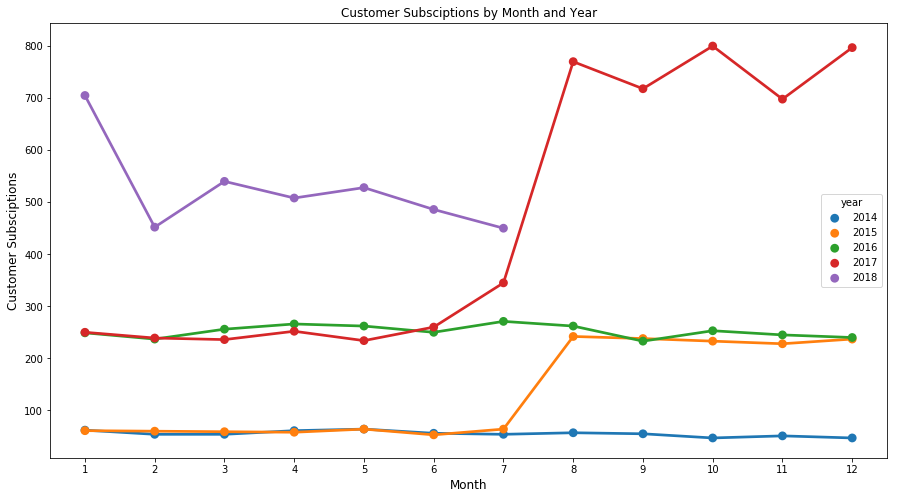

In [138]:
membership_subs = profile[profile['year'] >= 2014].groupby(['year','month'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="month", y="id", hue="year", data = membership_subs)
plt.ylabel('Customer Subsciptions', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.title('Customer Subsciptions by Month and Year');

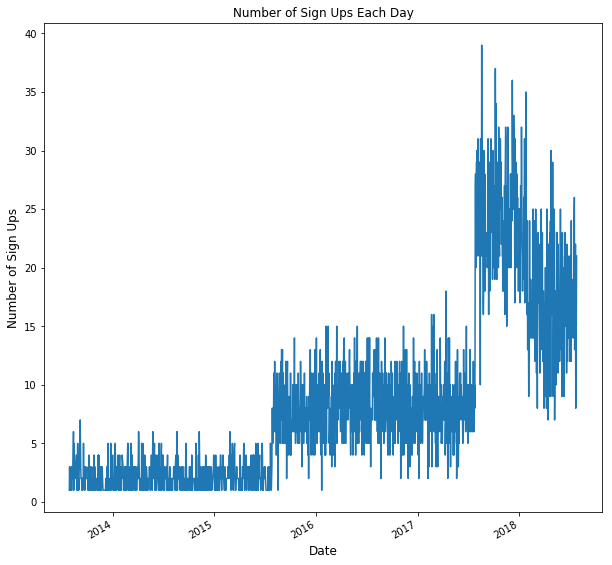

In [139]:
profile.date.value_counts().plot(kind = 'line', figsize = (10,10))
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Number of Sign Ups', fontsize = 12)
plt.title('Number of Sign Ups Each Day');

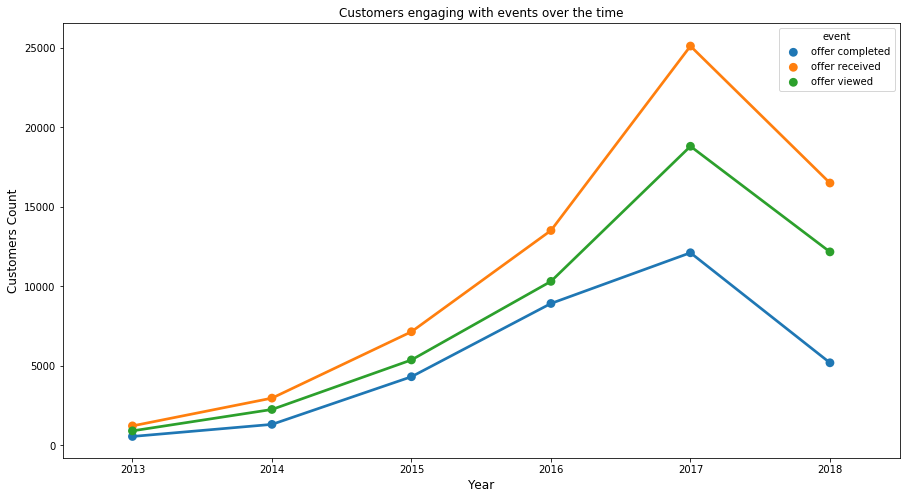

In [140]:
combined_data = combined[combined['time'] <= 1000].groupby(['event','year'], as_index=False).agg({'person':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="year", y="person", hue="event", data = combined_data)
plt.ylabel('Customers Count', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.title('Customers engaging with events over the time');

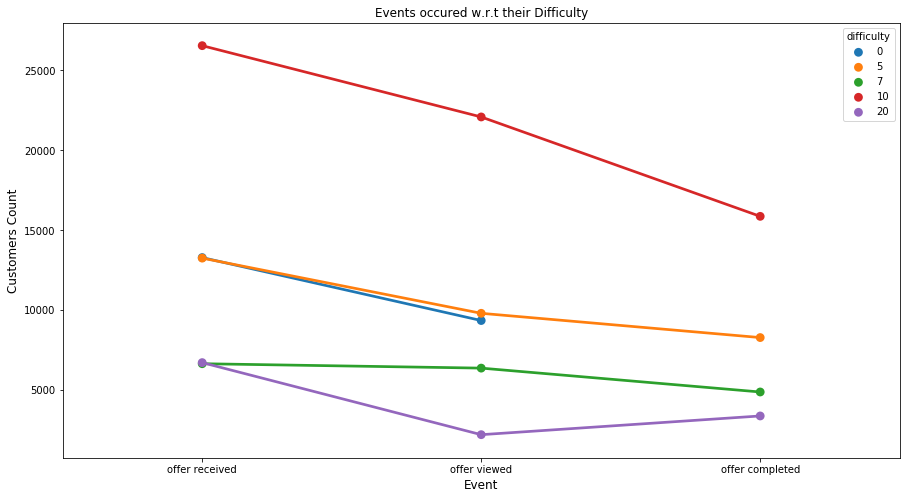

In [141]:
difficulty = all_data[all_data['age'] <= 100].groupby(['difficulty','event'], as_index=False).agg({'person':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="event", y="person", hue="difficulty", data = difficulty)
plt.ylabel('Customers Count', fontsize = 12)
plt.xlabel('Event', fontsize = 12)
plt.title('Events occured w.r.t their Difficulty');